In [56]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset
# read the sample data in
data_dir = './data/'
df = pd.read_csv(data_dir + "train.csv")
df = df.drop(["Unnamed: 0", "eqty_corp_family_tot"], axis=1)
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics

In [78]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn import metrics

In [33]:
import matplotlib.pyplot as plt

In [2]:
#1. Date Format:
for col in df.columns:
    if "date" in col:
        df[col] = pd.to_datetime(df[col])

    if col=="def_date":
        df["def_date"] = df["def_date"].fillna(pd.Timestamp("2099-12-31"))

#2. Generate Labels and drop any future-peeking rows
df["def_min"] = df["stmt_date"] + DateOffset(months=3)
df["def_max"] = df["stmt_date"] + DateOffset(months=15)
df["def_in_12mo"] = 0
df["def_in_12mo"] = df["def_in_12mo"].where(
    (df["def_date"]<df["def_min"]) | (df["def_date"]>df["def_max"]), 1)
# Future peeking rows
df = df[~(df["def_date"] < df["def_min"])].drop(["def_min", "def_max"], axis=1)

In [3]:
df = df.merge(pd.read_csv(data_dir + "ateco_code_industry.csv"), on ="ateco_sector", how="left").drop("ateco_sector", axis=1)  
    


In [4]:
#3. Filling in NA values:
dollar_cols = [col for col in df.columns if col not in ["HQ_city", "INDUSTRY", "def_date", "fs_year", "id", "legal_struct",
                                                        "roa", "roe", "stmt_date", "def_in_12mo", "asst_tot", "days_rec"]]
num_cols = ["roa", "roe"]
mean_df = pd.DataFrame()
for col in dollar_cols:
    temp = df.groupby("INDUSTRY", as_index=False).apply(lambda x : (x[col] / x["asst_tot"]).mean())
    temp.columns = ["INDUSTRY", col]
    if mean_df.empty:
        mean_df = temp
    else:
        mean_df = mean_df.merge(temp, on=["INDUSTRY"], how="left")
for col in num_cols:
    temp = df.groupby("INDUSTRY", as_index=False)[col].mean()
    temp.columns = ["INDUSTRY", col]
    mean_df = mean_df.merge(temp, on=["INDUSTRY"], how="left")

#5. FILL NA with industry specific means:
for col in dollar_cols:
    ind_mean = df[["INDUSTRY"]].merge(mean_df[["INDUSTRY", col]], on=["INDUSTRY"], how="left")[col]
    df[col] = df[col].where(~df[col].isnull(), ind_mean * df["asst_tot"])
for col in num_cols:
    ind_mean = df[["INDUSTRY"]].merge(mean_df[["INDUSTRY", col]], on=["INDUSTRY"], how="left")[col]
    df[col] = df[col].where(~df[col].isnull(), ind_mean)

#6. Calculate all relevant ratios:
df["liab_tot"] = df["asst_tot"] - df["eqty_tot"]


In [5]:
def _calc_fin_ratio(df):
    # Leverage Ratio
    out_cols =["debt_st_to_eqty_tot", 
               "eqty_tot_to_asst_tot",
               "debt_st_to_deb_tot",
               "debt_st_to_ebitda",
               "liq_curr_ratio",
               "liq_quick_ratio",
               "wc_net_to_asst_tot",
               "asst_tang_fixed_to_asst_tot",
               "asst_intang_fixed_to_asst_tot",
               "liq_cfo_ratio",
               "ebitda_to_asst_tot",
               "prof_operations_to_asst_tot",
               "ebitda_to_exp_financing",
               "AR_to_liab_tot"]
    
    df["debt_st_to_eqty_tot"] = (df["debt_st"] / df["eqty_tot"]).where(df["debt_st"]!=0, 0)
    df["eqty_tot_to_asst_tot"] = df["eqty_tot"] / df["asst_tot"]
    df["debt_st_to_deb_tot"] = (df["debt_st"] / (df["debt_st"] + df["debt_lt"])).where(df["debt_st"]!=0, 0)
    df["debt_st_to_ebitda"] = (df["debt_st"] / df["ebitda"]).where(df["debt_st"]!=0, 0)
    # Liquidity Ratio
    df["liq_curr_ratio"] = (df["asst_current"] / df["liab_tot"]).where(df["asst_current"]!=0, 0) # we don't have current asset or liability
    df["liq_quick_ratio"] = ((df["cash_and_equiv"] + df["AR"]) / df["liab_tot"]).where((df["cash_and_equiv"] + df["AR"])!=0, 0)
    df["wc_net_to_asst_tot"] = df["wc_net"] / df["asst_tot"]
    df["asst_tang_fixed_to_asst_tot"] = df["asst_tang_fixed"] / df["asst_tot"]
    df["asst_intang_fixed_to_asst_tot"] = df["asst_intang_fixed"] / df["asst_tot"]
    df["liq_cfo_ratio"] = (df["cf_operations"] / df["liab_tot"]).where(df["cf_operations"]!=0, 0)
    # Profitability Ratio
    df["ebitda_to_asst_tot"] = df["ebitda"] / df["asst_tot"]
    df["prof_operations_to_asst_tot"] = df["prof_operations"]/ df["asst_tot"]
    # Coverage Ratio
    df["ebitda_to_exp_financing"] = (df["ebitda"] / df["exp_financing"]).where(df["ebitda"]!=0, 0)
    # Activity Ratio
    df["AR_to_liab_tot"] = (df["AR"] / df["liab_tot"]).where(df["AR"]!=0, 0) # we don't have current asset or liability
    
    # now handle +/- inf situations:
    for col in out_cols:
        temp_arr = sorted(df[col].unique())
        df[col] = np.clip(df[col], a_min=temp_arr[1], a_max=temp_arr[-2])
    
    return df

In [6]:
rat_df = _calc_fin_ratio(df)

In [7]:
def _convert_dollars_to_asset_ratio(df, cols):
    for col in cols:
        if (col + "_to_asst_tot") not in df.columns:
            df[col + "_to_asst_tot"] = df[col] / df["asst_tot"]
    df = df.drop(cols, axis=1)
    return df
    

In [8]:
rat_df = _convert_dollars_to_asset_ratio(rat_df, dollar_cols)

## NO Need to RUN this part - skip

In [36]:
# 5. Factor Selection, investigation: 


In [11]:
corr = rat_df.corr()

In [12]:
pairwise = pd.melt(corr.reset_index(), id_vars="index").query("value.abs() > 0.75")
pairwise = pairwise.query("index!=variable")
pairwise["ABS_corr"] = pairwise["value"].abs()
pairwise = pairwise.sort_values(["ABS_corr"], ascending=False)
pairwise["pair"] = pairwise.apply(lambda x : "__".join(sorted([x["index"], x["variable"]])), axis=1)
pairwise = pairwise.drop_duplicates(subset=["pair"])
pairwise[["pair", "value", "ABS_corr"]].sort_values(["pair"])

,pair,value,ABS_corr
646,AR_to_liab_tot__liq_curr_ratio,0.963080,0.963080
694,AR_to_liab_tot__liq_quick_ratio,0.968271,0.968271
792,asst_current_to_asst_tot__asst_tang_fixed_to_a...,-0.839671,0.839671
387,asst_tot__liab_tot,0.945706,0.945706
1739,debt_lt_to_asst_tot__debt_st_to_deb_tot,-0.771938,0.771938
951,ebitda_to_asst_tot__goodwill_to_asst_tot,0.867485,0.867485
979,ebitda_to_asst_tot__prof_operations_to_asst_tot,0.998930,0.998930
999,goodwill_to_asst_tot__prof_operations_to_asst_tot,0.865561,0.865561
685,liq_curr_ratio__liq_quick_ratio,0.988870,0.988870
2157,profit_to_asst_tot__taxes_to_asst_tot,0.980882,0.980882


We notice multi-colinearity in many different factors - Need to reduce the number of factors

In [13]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [14]:
new_df = rat_df.sort_values("stmt_date")
train = new_df.iloc[:800000]
test = new_df.iloc[800000:]

no_standardize_cols = ['id', 'stmt_date', 'HQ_city', 'legal_struct', 'INDUSTRY','def_date', 'fs_year', "def_in_12mo"]


In [15]:

stdz_dict = {}

for col in train.columns:
    if col not in no_standardize_cols:
        stdz_dict[col] = [train[col].mean(), train[col].std()]
        train[col] = (train[col] - train[col].mean()) / train[col].std()

for col in stdz_dict.keys():
    test[col] = (test[col] - stdz_dict[col][0]) / stdz_dict[col][1]
        

factor_cols = []
score_cols = []
for col in set(pairwise["index"]).union(set(pairwise["variable"])):
    factor_cols.append(col)
    eqn = "def_in_12mo ~ %s" % col
    print(eqn)
    mod = smf.logit(formula = eqn , data = train)
    res = mod.fit(method="bfgs")
    pred_proba = res.predict(test)
    result = pd.DataFrame({"label" : test.def_in_12mo.tolist() , "proba" : pred_proba})
    result = result.sort_values("proba", ascending=False)
    def_rate = test["def_in_12mo"].sum() / len(test["def_in_12mo"])
    cutoff = int(def_rate * len(test))
    score = result.iloc[:cutoff]["label"].sum()
    score_cols.append(score)


C:\Users\Young Jin Park\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Young Jin Park\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


def_in_12mo ~ ebitda_to_asst_tot
Optimization terminated successfully.
         Current function value: 0.070377
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
def_in_12mo ~ prof_operations_to_asst_tot
Optimization terminated successfully.
         Current function value: 0.070372
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
def_in_12mo ~ liq_curr_ratio
Optimization terminated successfully.
         Current function value: 0.070390
         Iterations: 18
         Function evaluations: 19
         Gradient evaluations: 19
def_in_12mo ~ goodwill_to_asst_tot
Optimization terminated successfully.
         Current function value: 0.070388
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
def_in_12mo ~ taxes_to_asst_tot
Optimization terminated successfully.
         Current function value: 0.065162
         Iterations: 16
         Function evaluations: 17
    

In [16]:
factor_df = pd.DataFrame({"factor" : factor_cols, "score" : score_cols})

In [17]:
score_dict = dict(zip(factor_cols, score_cols))

In [18]:
pairwise["winner"] = pairwise.apply(lambda x : x["index"] if score_dict[x["index"]] >score_dict[x["variable"]] else x["variable"], axis=1)

In [19]:
pairwise.sort_values("variable")

,index,variable,value,ABS_corr,pair,winner
792,asst_current_to_asst_tot,asst_tang_fixed_to_asst_tot,-0.839671,0.839671,asst_current_to_asst_tot__asst_tang_fixed_to_a...,asst_current_to_asst_tot
1739,debt_st_to_deb_tot,debt_lt_to_asst_tot,-0.771938,0.771938,debt_lt_to_asst_tot__debt_st_to_deb_tot,debt_lt_to_asst_tot
951,goodwill_to_asst_tot,ebitda_to_asst_tot,0.867485,0.867485,ebitda_to_asst_tot__goodwill_to_asst_tot,ebitda_to_asst_tot
387,asst_tot,liab_tot,0.945706,0.945706,asst_tot__liab_tot,asst_tot
646,AR_to_liab_tot,liq_curr_ratio,0.963080,0.963080,AR_to_liab_tot__liq_curr_ratio,AR_to_liab_tot
685,liq_curr_ratio,liq_quick_ratio,0.988870,0.988870,liq_curr_ratio__liq_quick_ratio,liq_quick_ratio
694,AR_to_liab_tot,liq_quick_ratio,0.968271,0.968271,AR_to_liab_tot__liq_quick_ratio,liq_quick_ratio
979,ebitda_to_asst_tot,prof_operations_to_asst_tot,0.998930,0.998930,ebitda_to_asst_tot__prof_operations_to_asst_tot,prof_operations_to_asst_tot
999,goodwill_to_asst_tot,prof_operations_to_asst_tot,0.865561,0.865561,goodwill_to_asst_tot__prof_operations_to_asst_tot,prof_operations_to_asst_tot
2157,profit_to_asst_tot,taxes_to_asst_tot,0.980882,0.980882,profit_to_asst_tot__taxes_to_asst_tot,profit_to_asst_tot


## Run from this point on-ward

In [9]:
factors_to_exclude = ["AR_to_liab_tot", "ebitda_to_asst_tot", "goodwill_to_asst_tot", "liq_quick_ratio", "liq_curr_ratio", 
                      "taxes_to_asst_tot"]

In [10]:
rat_df = rat_df.drop(factors_to_exclude, axis=1)

In [11]:
chg_cols = [col for col in rat_df.columns if ((col in ["roe", "roa"]) or ("_to_" in col))]

In [12]:
rat_df = rat_df.sort_values(["id", "stmt_date"])
chg_df = rat_df[["id"] + chg_cols].groupby("id").diff().fillna(0)

In [13]:
chg_df.columns=[c+"_chg_1y" for c in chg_df.columns]

In [14]:
new_rat_df = rat_df.join(chg_df)

In [15]:
rat_df = rat_df.join(pd.get_dummies(df["INDUSTRY"]))

In [16]:
# 7. For Now drop city / year / stmt_date -- will add the back later :  

In [17]:
df.groupby(["INDUSTRY"], as_index=False)["id"].count().sort_values("id")

,INDUSTRY,id
12,PUBLIC_ADMINISTRATION_AND_DEFENCE__SOCIAL_INSU...,61
5,EXTRATERRITORIAL_ORGANIZATIONS_AND_BODIES,237
8,INSTRUCTION,1434
10,OTHER_SERVICE_ACTIVITIES,3633
4,EXTRACTION_OF_MINERALS_FROM_QUARRIES_AND_MINES,4580
2,ARTISTIC__SPORTS__ENTERTAINMENT_ACITIVIES,7796
6,HEALTH_AND_SOCIAL_ASSISTANCE,8787
16,SUPPLY_OF_WATER__SEWER_NETWORKS__MANAGEMENT_AC...,9417
15,SUPPLY_OF_ELECTRICITY__GAS__STEAM_AND_AIR_COND...,11538
1,AGRICULTURE__FORESTRY_AND_FISHING,17009


In [18]:
# Merge macro factors : 
m_fac = pd.read_csv(data_dir + "ita_macro_factors.csv")

In [19]:
new_rat_df = new_rat_df.merge(m_fac, on="fs_year", how="left")

In [20]:
new_rat_df = new_rat_df.sort_values("stmt_date")
df1 = new_rat_df.drop(["id", "stmt_date", "INDUSTRY", "fs_year", "legal_struct", "HQ_city", "def_date"], axis=1)
df1["days_rec"] = df1.days_rec.fillna(0)

In [21]:
df1.columns = [col.replace(" ", "_").replace(";","_").replace(",", "_") for col in df1.columns]

In [22]:
# simple train test =
split_n = int(0.8 * len(df))
train = df1[:split_n]
test = df1[split_n:]

In [23]:
no_standardize_cols = ['id', 'stmt_date', 'HQ_city', 'legal_struct', 'ateco_sector','def_date', 'fs_year', "def_in_12mo", "INDUSTRY"]

stdz_dict = {}

for col in train.columns:
    if col not in no_standardize_cols:
        print(col)
        stdz_dict[col] = [train[col].mean(), train[col].std()]
        train[col] = (train[col] - train[col].mean()) / train[col].std()

for col in stdz_dict.keys():
    print(col)
    test[col] = (test[col] - stdz_dict[col][0]) / stdz_dict[col][1]

asst_tot
days_rec
roa
roe
liab_tot
debt_st_to_eqty_tot
eqty_tot_to_asst_tot
debt_st_to_deb_tot
debt_st_to_ebitda
wc_net_to_asst_tot
asst_tang_fixed_to_asst_tot
asst_intang_fixed_to_asst_tot
liq_cfo_ratio
prof_operations_to_asst_tot


/Users/seonhyeyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


ebitda_to_exp_financing
asst_fixed_fin_to_asst_tot
asst_current_to_asst_tot
AR_to_asst_tot
cash_and_equiv_to_asst_tot
liab_lt_to_asst_tot
liab_lt_emp_to_asst_tot
debt_bank_st_to_asst_tot
debt_bank_lt_to_asst_tot
debt_fin_st_to_asst_tot
debt_fin_lt_to_asst_tot
AP_st_to_asst_tot
AP_lt_to_asst_tot
debt_st_to_asst_tot
debt_lt_to_asst_tot
rev_operating_to_asst_tot
COGS_to_asst_tot
inc_financing_to_asst_tot
exp_financing_to_asst_tot
prof_financing_to_asst_tot
inc_extraord_to_asst_tot
profit_to_asst_tot
margin_fin_to_asst_tot
cf_operations_to_asst_tot
roa_chg_1y
roe_chg_1y
debt_st_to_eqty_tot_chg_1y
eqty_tot_to_asst_tot_chg_1y
debt_st_to_deb_tot_chg_1y
debt_st_to_ebitda_chg_1y
wc_net_to_asst_tot_chg_1y
asst_tang_fixed_to_asst_tot_chg_1y
asst_intang_fixed_to_asst_tot_chg_1y
prof_operations_to_asst_tot_chg_1y
ebitda_to_exp_financing_chg_1y
asst_fixed_fin_to_asst_tot_chg_1y
asst_current_to_asst_tot_chg_1y
AR_to_asst_tot_chg_1y
cash_and_equiv_to_asst_tot_chg_1y
liab_lt_to_asst_tot_chg_1y
liab_lt_

/Users/seonhyeyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


# You can use Train and Test beyond this point

In [24]:
train_X = train[[col for col in train.columns if col!="def_in_12mo"]]
train_Y = train["def_in_12mo"]
test_X = test[[col for col in test.columns if col!="def_in_12mo"]]
test_Y = test["def_in_12mo"]


In [25]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
clf=RandomForestClassifier(n_estimators=5)
clf.fit(train_X,train_Y)

y_pred=clf.predict(test_X)

In [48]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(test_Y, y_pred))

Accuracy: 0.9888560983129983


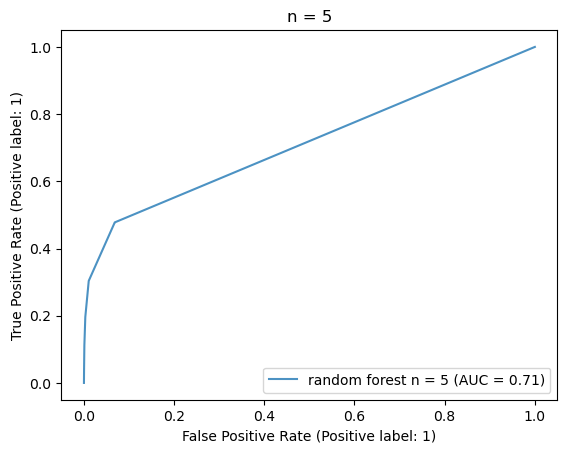

In [49]:
ax = plt.gca()
clf_disp1 = RocCurveDisplay.from_estimator(clf, test_X, test_Y, ax=ax, alpha=0.8, name = "random forest n = 5")
# svc_disp.plot(ax=ax, alpha=0.8)
plt.title("n = 5")
plt.show()

In [45]:
clf=RandomForestClassifier(n_estimators=10)
clf.fit(train_X,train_Y)

y_pred=clf.predict(test_X)

In [39]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(test_Y, y_pred))

Accuracy: 0.9900404743377038


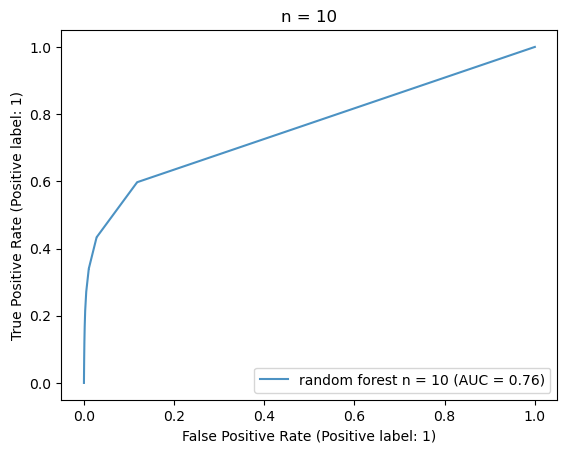

In [46]:
ax = plt.gca()
clf_disp2 = RocCurveDisplay.from_estimator(clf, test_X, test_Y, ax=ax, alpha=0.8, name = "random forest n = 10")
# svc_disp.plot(ax=ax, alpha=0.8)
plt.title("n = 10")
plt.show()

In [66]:
clf=RandomForestClassifier(n_estimators=15)
clf.fit(train_X,train_Y)

y_pred=clf.predict(test_X)


print("Accuracy:",metrics.accuracy_score(test_Y, y_pred))

Accuracy: 0.9899572743690261


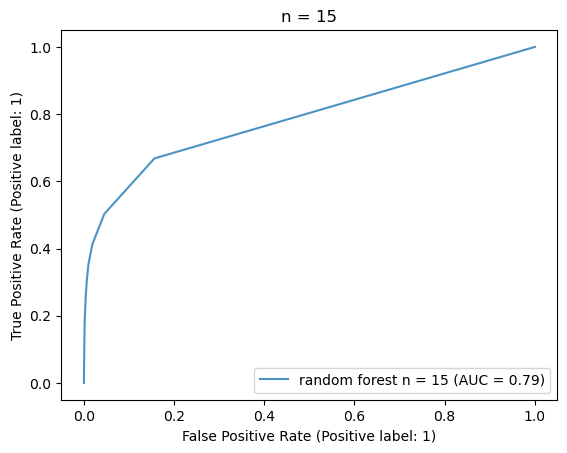

In [67]:
ax = plt.gca()
clf_disp3 = RocCurveDisplay.from_estimator(clf, test_X, test_Y, ax=ax, alpha=0.8, name = "random forest n = 15")
# svc_disp.plot(ax=ax, alpha=0.8)
plt.title("n = 15")
plt.show()

In [62]:
clf=RandomForestClassifier(n_estimators=20)
clf.fit(train_X,train_Y)

y_pred=clf.predict(test_X)


print("Accuracy:",metrics.accuracy_score(test_Y, y_pred))

Accuracy: 0.9900796272641403


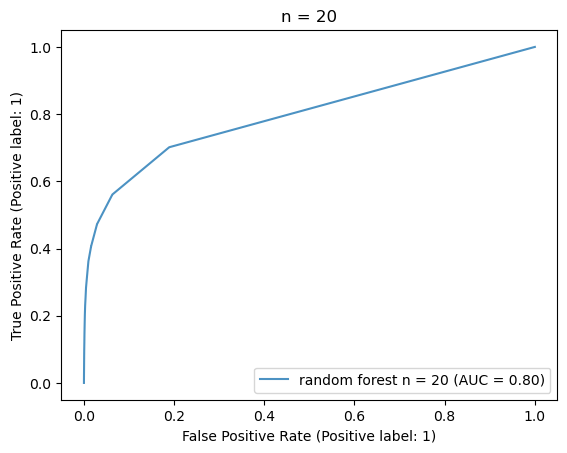

In [64]:
ax = plt.gca()
clf_disp4 = RocCurveDisplay.from_estimator(clf, test_X, test_Y, ax=ax, alpha=0.8, name = "random forest n = 20")
# svc_disp.plot(ax=ax, alpha=0.8)
plt.title("n = 20")
plt.show()

In [69]:
clf=RandomForestClassifier(n_estimators=50)
clf.fit(train_X,train_Y)

y_pred=clf.predict(test_X)


print("Accuracy:",metrics.accuracy_score(test_Y, y_pred))

Accuracy: 0.9902215566224728


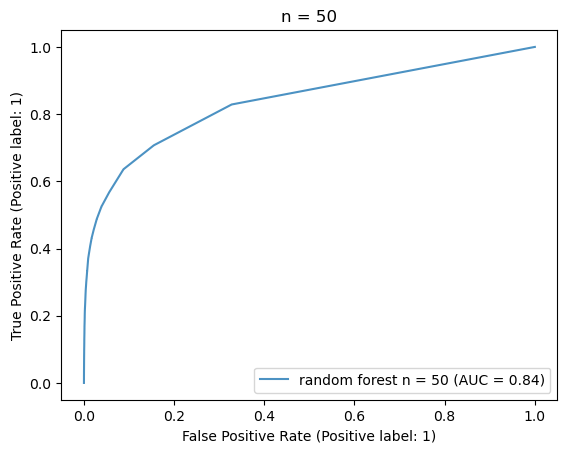

In [70]:
ax = plt.gca()
clf_disp5 = RocCurveDisplay.from_estimator(clf, test_X, test_Y, ax=ax, alpha=0.8, name = "random forest n = 50")
# svc_disp.plot(ax=ax, alpha=0.8)
plt.title("n = 50")
plt.show()

In [72]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(train_X,train_Y)

y_pred=clf.predict(test_X)


print("Accuracy:",metrics.accuracy_score(test_Y, y_pred))

Accuracy: 0.9901579331170134


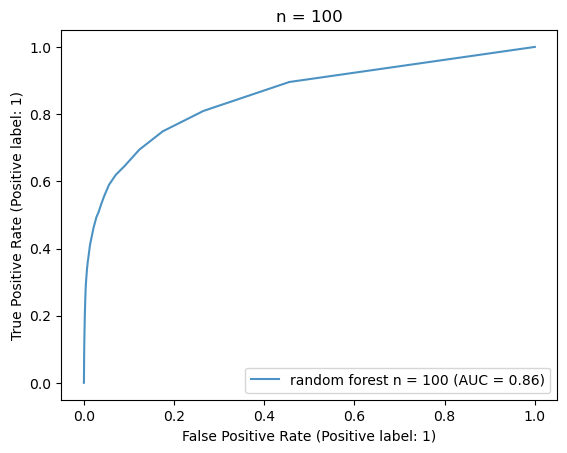

In [74]:
ax = plt.gca()
clf_disp6 = RocCurveDisplay.from_estimator(clf, test_X, test_Y, ax=ax, alpha=0.8, name = "random forest n = 100")
# svc_disp.plot(ax=ax, alpha=0.8)
plt.title("n = 100")
plt.show()

# Random Forest ROC

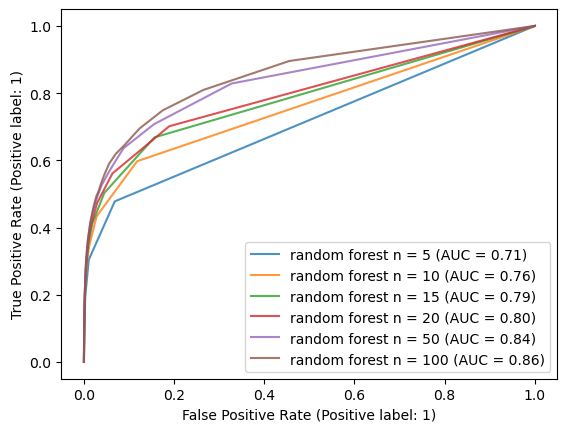

In [75]:
ax = plt.gca()
clf_disp1.plot(ax=ax, alpha=0.8)
clf_disp2.plot(ax=ax, alpha=0.8)
clf_disp3.plot(ax=ax, alpha=0.8)
clf_disp4.plot(ax=ax, alpha=0.8)
clf_disp5.plot(ax=ax, alpha=0.8)
clf_disp6.plot(ax=ax, alpha=0.8)

plt.show()

# Decision Trees

In [107]:
clf = DecisionTreeClassifier()
clf = clf.fit(train_X, train_Y)
y_pred = clf.predict(test_X)

In [108]:
print("Accuracy:",metrics.accuracy_score(test_Y, y_pred))

Accuracy: 0.9755489974403775


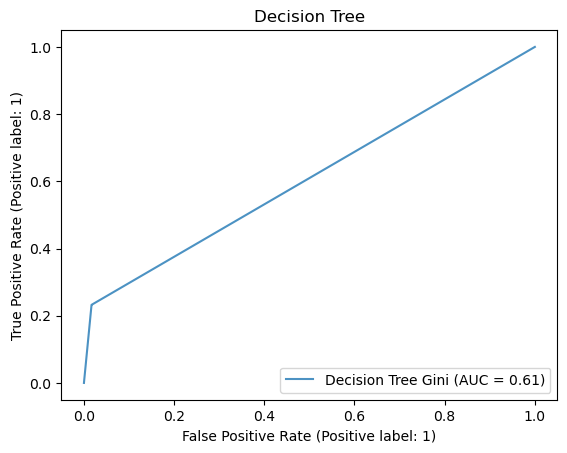

In [109]:
ax = plt.gca()
clf_disp = RocCurveDisplay.from_estimator(clf, test_X, test_Y, ax=ax, alpha=0.8, name = "Decision Tree Gini")
# svc_disp.plot(ax=ax, alpha=0.8)
plt.title("Decision Tree")
plt.show()

# Optimizing Decision Tree Performance

In [96]:
clf = DecisionTreeClassifier(criterion="entropy")
clf = clf.fit(train_X, train_Y)
y_pred = clf.predict(test_X)

In [97]:
print("Accuracy:",metrics.accuracy_score(test_Y, y_pred))

Accuracy: 0.9765669735277276


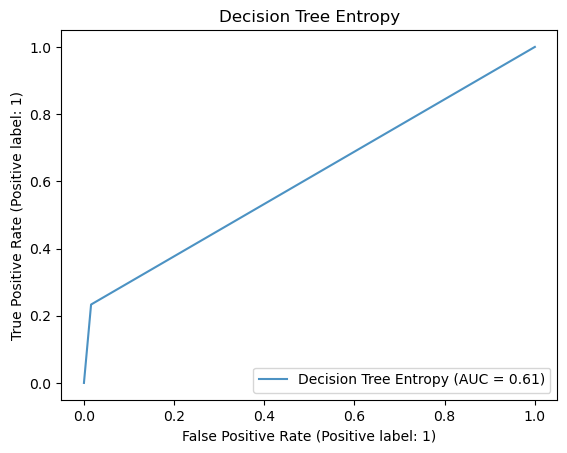

In [100]:
ax = plt.gca()
clf_disp1 = RocCurveDisplay.from_estimator(clf, test_X, test_Y, ax=ax, alpha=0.8, name = "Decision Tree Entropy")
# svc_disp.plot(ax=ax, alpha=0.8)
plt.title("Decision Tree Entropy")
plt.show()

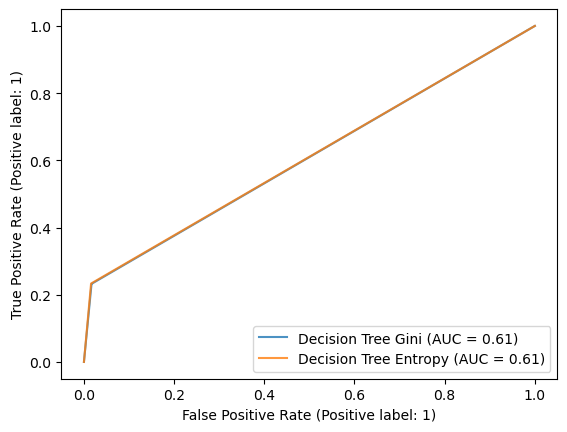

In [110]:
ax = plt.gca()
clf_disp.plot(ax=ax, alpha=0.8)
clf_disp1.plot(ax=ax, alpha=0.8)
# clf_disp2.plot(ax=ax, alpha=0.8)

plt.show()

## Logit model

In [52]:
### Logit
logit_eqn = "def_in_12mo ~ " + " + ".join(train_X.columns.tolist())

In [53]:
mod = smf.logit(formula = logit_eqn , data = train)
res = mod.fit(method="bfgs")
pred_proba = res.predict(test)
result = pd.DataFrame({"label" : test.def_in_12mo.tolist() , "proba" : pred_proba})
result = result.sort_values("proba", ascending=False)
def_rate = test["def_in_12mo"].sum() / len(test["def_in_12mo"])
cutoff = int(def_rate * len(test))
score = result.iloc[:cutoff]["label"].sum() / len(result)


         Current function value: 0.057580
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


C:\Users\Young Jin Park\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Young Jin Park\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [54]:
score

0.0030196694514185596

In [55]:
def_rate

0.01025806672637488

In [56]:
actu = test["def_in_12mo"].tolist()
fpr, tpr, thres = roc_curve(actu, pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

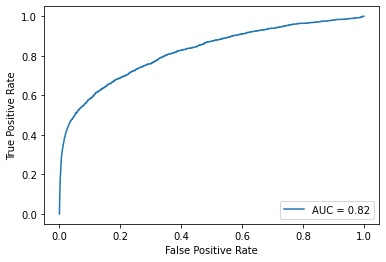

In [57]:
from sklearn import metrics
from matplotlib import pyplot
%matplotlib inline

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

## Calibrating PD

Calibration Step - adjust predicted PD to actual level PD

In [76]:
def calc_adj_factor(result, n_q=50):
    """
    Input:
    result : pd.DataFrame() - result should have at least two columns : label / proba (proba : predicted probability from the model) 
    n_q : number of quantiles to use
    
    Output: 
    adjustment : pd.DataFrame() - result would have two columns : bin / adj_factor
    bin : bins used for qcut
    """
    pred_bin, bins = pd.qcut(result["proba"], q=n_q, labels=50 - np.arange(n_q), retbins=True)
    adj_result = result.copy(deep=True)
    adj_result["bin"] = pred_bin
    
    # calc adjustment factor
    actual_prob = adj_result.groupby("bin", as_index=False)["label"].mean()
    pred_prob = adj_result.groupby("bin", as_index=False)["proba"].mean()
    adjustment = actual_prob.merge(pred_prob, on="bin", how="left")
    adjustment["adj_factor"] = adjustment["label"] / adjustment["proba"]
    
    return adjustment, bins
    
    

In [77]:
adj_fact, bins = calc_adj_factor(result, n_q=50)

NameError: name 'result' is not defined

In [159]:
def apply_adj_factor(result, adj_factor, bins):
    """
    Input:
    result : pd.DataFrame() - result should have at least one column : proba
    adj_factor, bins : output of calc_adj_factor
    
    output
    result : pd.DataFrame() - now proba is adjusted proba
    """
    
    adj_result = result.copy(deep=True)
    n_q = len(bins)-1
    adj_result["bin"] = pd.cut(adj_result["proba"], bins=bins, labels = n_q - np.arange(n_q), include_lowest=True)
    # deal with probability that are outside of the bins (which shouldn't be many..)
    adj_result.loc[(adj_result["bin"].isnull()) & (adj_result["proba"] < bins.min()), "bin"] = n_q
    adj_result.loc[(adj_result["bin"].isnull()) & (adj_result["proba"] > bins.max()), "bin"] = 1
    
    adj_result = adj_result.merge(adj_factor[["bin", "adj_factor"]], on="bin", how="left")
    adj_result["proba"] = adj_result["proba"] * adj_result["adj_factor"]
    
    return adj_result
    
    

In [160]:
adj_result = apply_adj_factor(result, adj_fact, bins)

Pre calibrated AUC curve

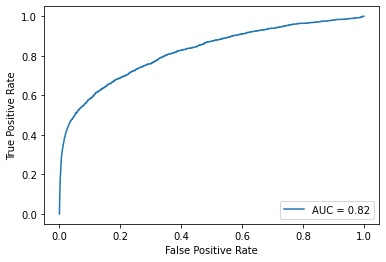

In [165]:
fpr, tpr, thres = roc_curve(result["label"], result["proba"], pos_label=1)
roc_auc = auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

Post Calibrated AUC curve

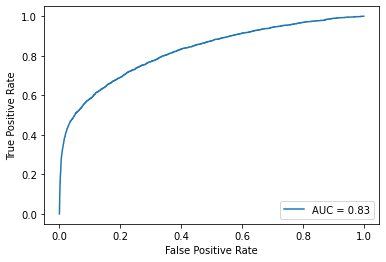

In [166]:
fpr, tpr, thres = roc_curve(adj_result["label"], adj_result["proba"], pos_label=1)
roc_auc = auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

Total PD comparison : pre-calibration / post-calibration

In [168]:
result.proba.mean()

0.022677787054394275

In [169]:
adj_result.proba.mean()

0.010258066726374884

In [170]:
adj_result.label.mean()

0.01025806672637488